<a href="https://colab.research.google.com/github/augustxj/Transfer-Learning-/blob/main/WBCTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WARNING
The errors mentioned above (overfitting and class bias), I BELIEVE, are due to the similarity between lymphocytes and monocytes, which was actually my main reason for undertaking this project. I've done some comments in which I think may improve it but i'm not sure about those. Feel free to improve, correct, or modify anything here. Your input will be incredibly valuable for my learning process.

Contact: joao.gonzaga@sou.unifal-mg.edu.br


# DATABASE
First, I am uploading the database. My version is updated on GitHub and was adapted from: [White Blood Cells Dataset on Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/white-blood-cells-dataset?select=Train) for educational purposes.

If you take a look, the database was already separated into `Train` and `Test` folders. To rearrange it according to the provided example (dogs and cats), I used the following `.py` script on my computer:



```
import os
import shutil

# pathway to original folders
original_dirs = [
    "C:/Users/joao_/OneDrive/Documents/GitHub/transferlearning/dataset/Train",
    "C:/Users/joao_/OneDrive/Documents/GitHub/transferlearning/dataset/Test-A",
    "C:/Users/joao_/OneDrive/Documents/GitHub/transferlearning/dataset/Test-B"
]

# Pathway to new folder
target_dir = "C:/Users/joao_/OneDrive/Documents/GitHub/transferlearning/newdata"

# Classes (subpastas a unificar)
classes = ["Lymphocyte", "Monocyte"]

# Limiting images per classes (I was having problem with Collab RAM limit)
max_images = 300

# Creating final structure
for class_name in classes:
    os.makedirs(os.path.join(target_dir, class_name), exist_ok=True)

# bonding folders
for class_name in classes:
    all_images = []  # Lista para armazenar caminhos das imagens
    
    # Coletar imagens de todas as pastas originais
    for original_dir in original_dirs:
        source_dir = os.path.join(original_dir, class_name)
        if os.path.exists(source_dir):
            all_images.extend([
                os.path.join(source_dir, filename)
                for filename in os.listdir(source_dir)
            ])
    
    # selection by the image limit
    selected_images = all_images[:max_images]
    
    # copying selected images to the final folder
    target_class_dir = os.path.join(target_dir, class_name)
    for image_path in selected_images:
        target_file = os.path.join(target_class_dir, os.path.basename(image_path))
        if not os.path.exists(target_file):  # Evitar duplicados
            shutil.copy(image_path, target_file)

print(f"Dataset unified at {target_dir} with maximum {max_images} images per class.")
```





####Yes I verified: all images in the Lymphocyte folder are Lymphocytes and all images in the Monocyte folder are Monocytes.

In [25]:
!git clone https://github.com/augustxj/Transfer-Learning-.git

fatal: destination path 'Transfer-Learning-' already exists and is not an empty directory.


In [26]:
%matplotlib inline

import os

import random
import numpy as np
import keras
import zipfile

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Just to make sure we're on the right directory:

In [27]:
print("Current working directory:", os.getcwd())

dataset_path = './Transfer-Learning-/dataset - WBC'
try:
    print("Files in the directory Dataset - WBC:", os.listdir(dataset_path))
except FileNotFoundError:
    print("Directory not found:", dataset_path)

Current working directory: /content
Files in the directory Dataset - WBC: ['Monocyte', 'Lymphocyte']


In [28]:
root = dataset_path
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['./Transfer-Learning-/dataset - WBC/Monocyte', './Transfer-Learning-/dataset - WBC/Lymphocyte']


This function is useful for pre-processing the data into an image and input vector.

In [29]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [30]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        # Check if x is not None before appending to data
        if x is not None:
            data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

checking again:

In [31]:
print(f"Total images processed successfully: {len(data)}")

from collections import Counter
class_distribution = Counter([d['y'] for d in data])
print(f"Class distribution: {class_distribution}")


Total images processed successfully: 600
Class distribution: Counter({0: 300, 1: 300})


Randomize the data order.

In [32]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [33]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [34]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [35]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(90, 2)


Let's get a summary of what we have.

In [36]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 600 images from 2 categories
train / validation / test split: 420, 90, 90
training data shape:  (420, 224, 224, 3)
training labels shape:  (420, 2)


let's take a look on our images:


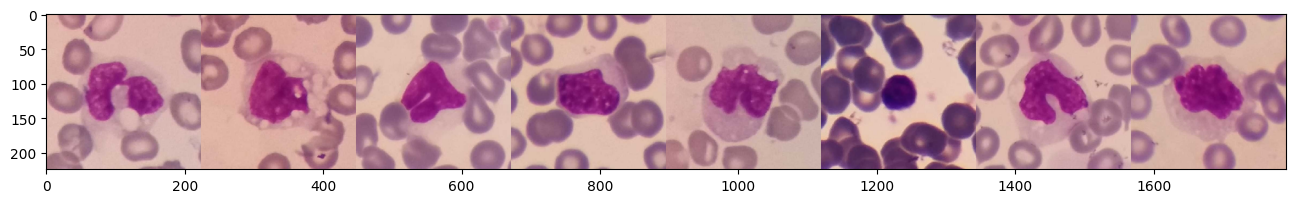

In [37]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [38]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [39]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5190 - loss: 0.6990 - val_accuracy: 0.9333 - val_loss: 0.6242
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8183 - loss: 0.5575 - val_accuracy: 0.8222 - val_loss: 0.4135
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8613 - loss: 0.3424 - val_accuracy: 0.9556 - val_loss: 0.1572
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9479 - loss: 0.1376 - val_accuracy: 0.9556 - val_loss: 0.0894
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9641 - loss: 0.0951 - val_accuracy: 0.9667 - val_loss: 0.0558
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9750 - loss: 0.0693 - val_accuracy: 0.9778 - val_loss: 0.0449
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9697 - loss: 0.0488 - val_accuracy: 0.9778 - val_loss: 0.0459
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9847 - loss: 0.0586 - val_accuracy: 0.9778 - val_loss: 0.

Let's plot the validation loss and validation accuracy over time.

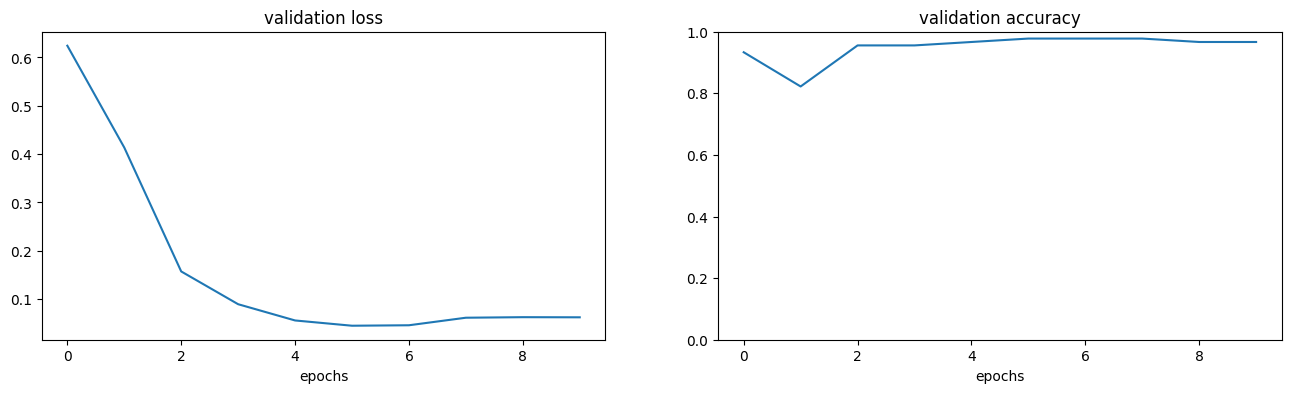

In [40]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [41]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.13491752743721008
Test accuracy: 0.9444444179534912


In [56]:
from sklearn.metrics import classification_report

# Gera predições para o conjunto de teste
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Converte probabilidades para classes

# Relatório de classificação
print(classification_report(y_test.argmax(axis=1), y_pred_classes, target_names=["Lymphocyte", "Monocyte"]))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

  Lymphocyte       0.92      0.98      0.95        46
    Monocyte       0.98      0.91      0.94        44

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90



The classification report shows the performance metrics for each class (lymphocytes and monocytes). The overall accuracy is 94%, indicating that the model classifies most images correctly. The precision for monocytes (0.98) is higher, meaning the model rarely misclassifies images as monocytes incorrectly. However, the recall for monocytes (0.91) is slightly lower, showing that the model misses some monocytes. Both classes have balanced F1-scores, which are a harmonic mean of precision and recall. This suggests the model is performing well overall.


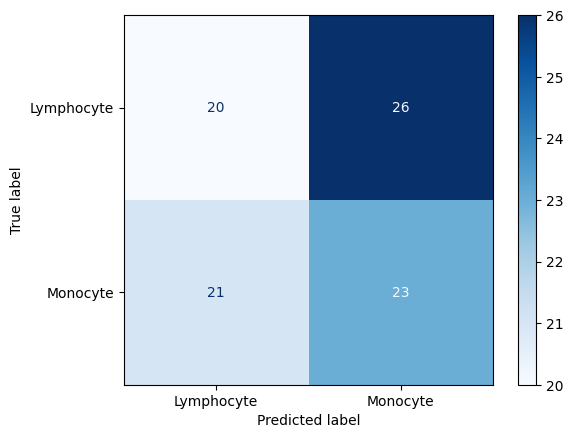

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_classes)

# Plot da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lymphocyte", "Monocyte"])
disp.plot(cmap='Blues')
plt.show()

The confusion matrix highlights the number of correct and incorrect classifications for lymphocytes and monocytes. While 20 lymphocytes and 23 monocytes were classified correctly, there are still notable misclassifications: 26 lymphocytes were classified as monocytes, and 21 monocytes were classified as lymphocytes. This indicates room for improvement, particularly in reducing false negatives for both classes. Adjusting class weights or improving data diversity may help mitigate these errors.


In [80]:
# Making a prediction from an image after training

# Function to preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define class names
class_names = ["Lymphocyte", "Monocyte"]

# Image path (i uploaded this one from a test folder in the original archive
# which were used neither in train or test here)
img_path = "lin3.jpg"

# Pre-process the image
img_array = preprocess_image(img_path)

# Prediction
probabilities = model.predict(img_array)
predicted_class_index = np.argmax(probabilities)
predicted_class_name = class_names[predicted_class_index]

print(f"Prediction: it's a {predicted_class_name}")
print(f"Probabilities: {probabilities}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: it's a Monocyte
Probabilities: [[3.3000888e-05 9.9996698e-01]]


It looks like all images are being classified as Monocytes

The model is exhibiting a behavior known as **class bias**, where all images, regardless of their actual content, are being classified as "monocyte." This issue can be caused by several factors, including:

1. **Dataset Imbalance:** Although the dataset contains 300 images per class, it is important to ensure that this balance is maintained across the training, validation, and test splits.

2. **Training Bias:** The model might be minimizing the loss by overly focusing on the class that is easier to identify or dominates the training process.

3. **Visual Similarity:** If lymphocytes and monocytes share very similar visual characteristics, the model might not be capturing the subtle differences necessary for differentiation.

4. **Lack of Final Adjustments in Transfer Learning:** The model might require additional fine-tuning (e.g., unfreezing convolutional layers) to learn features that are specific to the dataset.

#### Possible Solutions to Address the Issue
- **Verify Dataset Balance:** Ensure that the classes are evenly distributed across all dataset splits (training, validation, and test).
- **Adjust Class Weights:** Use class weights during training to penalize the underrepresented class more heavily.
- **Apply Data Augmentation:** Introduce variations in the dataset to increase diversity and help the model identify class-specific patterns.
- **Unfreeze Pre-trained Layers:** Fine-tune the last convolutional layers of the pre-trained model to allow it to learn features specific to this dataset.

The current behavior indicates that the model requires further adjustments to improve generalization and properly distinguish between lymphocytes and monocytes.


#Transfer Learning Implemention

In [43]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [44]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [45]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [46]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 15s/step - accuracy: 0.5242 - loss: 0.9507 - val_accuracy: 0.4556 - val_loss: 0.9920
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 553ms/step - accuracy: 0.5439 - loss: 0.8155 - val_accuracy: 0.5444 - val_loss: 0.7080
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.5375 - loss: 0.7165 - val_accuracy: 0.4556 - val_loss: 0.7000
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.5862 - loss: 0.6409 - val_accuracy: 0.5667 - val_loss: 0.6033
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - accuracy: 0.5574 - loss: 0.6393 - val_accuracy: 0.7111 - val_loss: 0.5693
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step - accuracy: 0.6723 - loss: 0.5886 - val_accuracy: 0.8000 - val_loss: 0.5147
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step - accuracy: 0.7290 - loss: 0.5585 - val_accuracy: 0.8000 - val_loss: 0.5049
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step - accuracy: 0.7124 - loss: 0.5620 - val_accuracy: 0.8222 - val_loss:

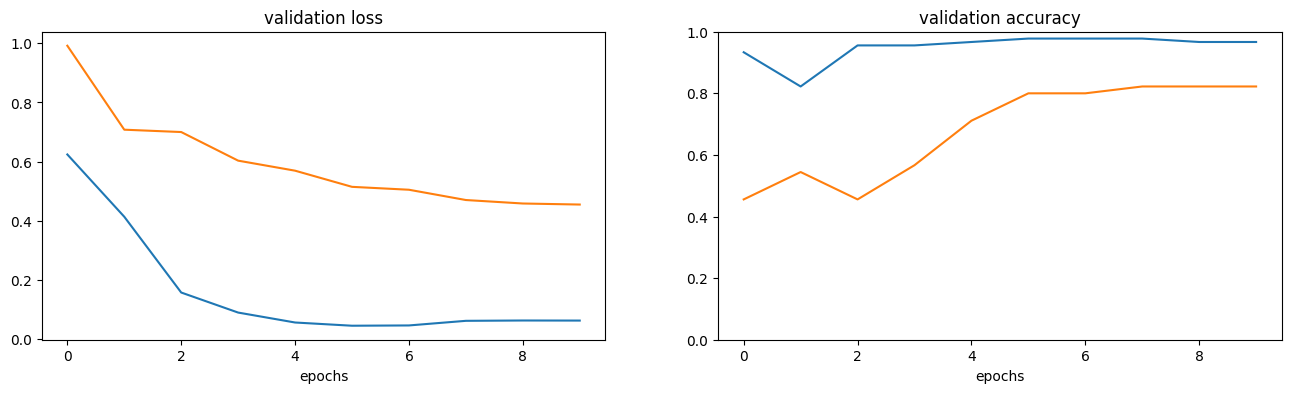

In [47]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

### Analysis of Validation Loss and Validation Accuracy Graphs

The graphs show the comparison between two models:
- **Blue Line:** Represents the performance of the baseline model (trained from scratch).
- **Orange Line:** Represents the performance of the Transfer Learning model.

#### **Validation Loss**
- The **blue line** (baseline) shows a rapid decline in validation loss, stabilizing close to 0.1 after a few epochs. This suggests that the baseline model is learning effectively from the dataset. However, its behavior could also indicate **class bias**, where the model achieves low loss by over-predicting one class (e.g., monocytes) at the expense of the other.
- The **orange line** (Transfer Learning) also shows a decline in validation loss but stabilizes at a higher value (~0.4). While its loss is higher, this could reflect a more balanced consideration of both classes, as it avoids class bias.

#### **Validation Accuracy**
- The **blue line** starts with a high validation accuracy (~90%) and quickly stabilizes around 98%-99%. This high accuracy may be artificially inflated due to class bias, where the baseline model achieves high accuracy by consistently predicting the majority or easier class (e.g., monocytes) while ignoring others.
- The **orange line** begins with lower accuracy but improves gradually over epochs, stabilizing at around 80%. This more gradual and steady progression suggests that the Transfer Learning model is attempting to generalize better across both classes, though it still requires adjustments to reach optimal performance.

#### **Key Observations**
1. **Baseline Model (Blue):**
   - While the metrics suggest superior performance, the potential for **class bias** must be considered. If the model is over-predicting monocytes, the high accuracy and low loss may not accurately reflect its ability to generalize across both classes.
   - Further evaluation on a balanced test set and detailed metrics (e.g., recall, precision, confusion matrix) is critical to confirm its true performance.

2. **Transfer Learning Model (Orange):**
   - Although it shows slower progress and lower accuracy, the model is likely less biased and may generalize better to unseen data.
   - The higher loss and lower accuracy indicate room for improvement, such as fine-tuning the pre-trained layers or increasing the diversity of the training data.

#### **Recommendations**
- Investigate the **class bias** of the baseline model by analyzing detailed metrics (precision, recall, F1-score) and confusion matrices on a test set.
- Fine-tune the Transfer Learning model by unfreezing more layers of the pre-trained backbone to allow learning of domain-specific features.
- Consider balancing the dataset further or using **class weights** during training to ensure both models treat classes equally.

This updated analysis acknowledges the possibility of class bias in the baseline model and emphasizes the importance of validating its true performance using class-specific metrics.


In [48]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4760597348213196
Test accuracy: 0.8333333134651184


To predict a new image, simply run the following code to get the probabilities for each class.

In [79]:
# Setting class names
class_names = ["Lymphocyte", "Monocyte"]

# getting prediction of probabilities
img, x = get_image('lin3.jpg')
probabilities = model_new.predict([x])

# finding the class index with higher probabilitie
predicted_class_index = probabilities.argmax()

# Converting index to class name
predicted_class_name = class_names[predicted_class_index]

print(f"Probabilidades: {probabilities}")
print(f"Predição: É um {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Probabilidades: [[0.00520628 0.9947937 ]]
Predição: É um Monocyte


### Observation on Bias in the Transfer Learning Model

The Transfer Learning model demonstrates a tendency to classify images as "monocyte," even when the image belongs to the "lymphocyte" class. This indicates a **class bias**, which may be caused by:
1. Visual differences favoring monocytes.
2. Characteristics of the pre-trained layers from the base model (e.g., ImageNet features).
3. The default threshold used for classification.

#### Possible Solutions:
- Adjust class weights to penalize misclassification of lymphocytes more heavily.
- Unfreeze layers in the base model to allow learning of domain-specific features.
- Apply data augmentation to increase the diversity of the training dataset.
- Experiment with a dynamic threshold to improve sensitivity for lymphocytes.

This analysis suggests that the model requires additional adjustments to reduce bias and improve generalization across both classes.


In [67]:
y_pred = model_new.predict(x_val)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_val.argmax(axis=1), y_pred_classes, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
              precision    recall  f1-score   support

  lymphocyte       0.90      0.76      0.82        49
    Monocyte       0.76      0.90      0.82        41

    accuracy                           0.82        90
   macro avg       0.83      0.83      0.82        90
weighted avg       0.84      0.82      0.82        90



### Transfer Learning Model Classification Report Summary

The model achieves an overall accuracy of 82% with balanced F1-scores (0.82) for both classes, lymphocyte and monocyte. While precision is higher for lymphocytes (0.90), recall is stronger for monocytes (0.90), indicating the model prioritizes correctly identifying monocytes but misses some lymphocytes (recall: 0.76).

#### **Key Observations:**
1. **Balanced Performance:** Both classes are treated fairly, with similar F1-scores.
2. **Recall Gap:** Lower recall for lymphocytes suggests some are being misclassified.
3. **Improvement Opportunities:**
   - Adjust class weights to enhance lymphocyte recall.
   - Apply fine-tuning to capture more specific patterns.
   - Use data augmentation for greater diversity in training.

The model demonstrates a solid starting point but could benefit from adjustments to improve recall and overall generalization.


##Improving the Results
Achieving an accuracy of 82% on a 2-class dataset (lymphocytes and monocytes) is a promising result, but there is clear room for improvement. The potential bias towards monocytes, as observed during testing, suggests that the model can benefit from additional adjustments to enhance its generalization and sensitivity to lymphocytes. Some techniques that could potentially improve performance include:

Using Data Augmentation: Apply various transformations to the training data, such as rotations, flips, zooms, lighting changes, and rescaling, to increase dataset diversity. This can help the model better distinguish between lymphocytes and monocytes and build tolerance to small variations in the images.

Fine-Tuning the Pre-trained Model: Unfreeze more layers of the pre-trained VGG16 backbone to allow it to learn domain-specific features from the dataset. This could help address the challenge of visual similarities between the two classes.

Adjusting Class Weights: Penalize errors in lymphocyte classification more heavily by assigning higher weights to the lymphocyte class during training. This could help reduce the observed bias towards monocytes.

Experimenting with Hyperparameters: Explore different optimizers (e.g., Adam, RMSprop) or tune learning rates, dropout rates, and regularization to improve convergence and reduce overfitting.

Training for Longer: If early stopping was used, allow the model to train for more epochs, particularly with regularization, to improve performance without risking overfitting.

While the current results demonstrate the effectiveness of Transfer Learning in this problem, addressing the above aspects could lead to better generalization and a more balanced performance across both classes.